In [1]:
import matplotlib.pyplot as plt

In [2]:
from ezedgeai_core import Component
from ezedgeai_core import Input
from ezedgeai_core import Output
from ezedgeai_core import Connection

In [3]:
from ezedgeai_classify_heartbeats import ClassifyHeartbeatsModelProcedure
from ezedgeai_classify_heartbeats import MitBihArrhythmiaDatasetProcedure
from ezedgeai_classify_heartbeats import DatasetSplitProcedure
from ezedgeai_classify_heartbeats import TeeProcedure
from ezedgeai_classify_heartbeats import ClassifyHeartbeatsModelTrainProcedure
from ezedgeai_classify_heartbeats import ClassifyHeartbeatsModelEvaluteProcedure
from ezedgeai_classify_heartbeats import ConvertToTFLiteModelProcedure

In [4]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel('train')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [5]:
model = Component( 'Model' , None, None, ClassifyHeartbeatsModelProcedure() )
model.bind_port( 'model', Output() )

dataset = Component( 'Dataset' , None, None, MitBihArrhythmiaDatasetProcedure() )
dataset.bind_port( 'dataset', Output())

split = Component( 'Split' , None, None, DatasetSplitProcedure() )
split.bind_port( 'dataset', Input())
split.bind_port( 'train_data', Output())
split.bind_port( 'test_data', Output())


tee1 = Component( 'Tee1' , None, None, TeeProcedure() )
tee1.bind_port( 'input', Input()) 
tee1.bind_port( 'output1', Output()) 
tee1.bind_port( 'output2', Output()) 

model_train = Component( 'Model Train' , None, None, ClassifyHeartbeatsModelTrainProcedure() )
model_train.bind_port( 'model_in', Input())
model_train.bind_port( 'train_data', Input())
model_train.bind_port( 'model_out', Output())

tee2 = Component( 'Tee2' , None, None, TeeProcedure() )
tee2.bind_port( 'input', Input()) 
tee2.bind_port( 'output1', Output()) 
tee2.bind_port( 'output2', Output())

model_evaluate = Component( 'Model Evaluate' , None, None, ClassifyHeartbeatsModelEvaluteProcedure(show_confusion_matrix=True) )
model_evaluate.bind_port( 'model', Input())
model_evaluate.bind_port( 'test_data', Input())

model_converter = Component( 'Model Converter' , None, None, ConvertToTFLiteModelProcedure(compile_micro_model=True) )
model_converter.bind_port( 'model', Input())
model_converter.bind_port( 'train_data', Input())

In [6]:
connect1 = Connection( model.get_port( 'model' ), model_train.get_port( 'model_in' ) )
connect2 = Connection( dataset.get_port( 'dataset' ), split.get_port( 'dataset' ) )
connect3 = Connection( split.get_port( 'train_data' ), tee1.get_port( 'input' ) )
connect4 = Connection( tee1.get_port( 'output1' ), model_train.get_port( 'train_data' ) )
connect5 = Connection( model_train.get_port( 'model_out' ), tee2.get_port( 'input' ) )
connect6 = Connection( tee2.get_port( 'output1' ), model_evaluate.get_port( 'model' ) )
connect7 = Connection( split.get_port( 'test_data' ), model_evaluate.get_port( 'test_data' ) )
connect8 = Connection( tee2.get_port( 'output2' ), model_converter.get_port( 'model' ) )
connect9 = Connection( tee1.get_port( 'output2' ), model_converter.get_port( 'train_data' ) )

In [7]:
connect1.connect()
connect2.connect()
connect3.connect()
connect4.connect()
connect5.connect()
connect6.connect()
connect7.connect()
connect8.connect()
connect9.connect()

In [8]:
model.process()
dataset.process()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 260)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 260, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 258, 5)            20        
_________________________________________________________________
re_lu (ReLU)                 (None, 258, 5)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 129, 5)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 126, 10)           210       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 126, 10)           0     

In [9]:
train_history = model_train.get_property('train_history')

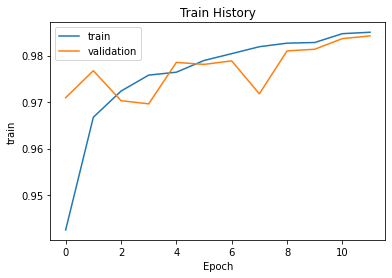

In [10]:
show_train_history(train_history, 'categorical_accuracy', 'val_categorical_accuracy')

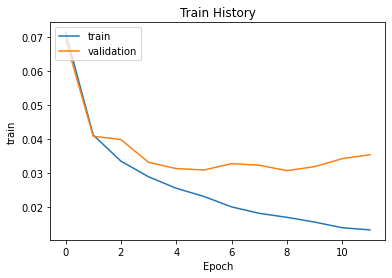

In [11]:
show_train_history(train_history, 'loss', 'val_loss')